In [1]:
import h5py as h5
import numpy as np
import pandas as pd
from pandas import HDFStore 
import matplotlib.pyplot as plt
import seaborn as sns
from math import erfc
import sys
from scipy import special
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis



# DATA ACQUISITION

In [2]:
file = h5.File("SG24_dataset.h5",'r')
X = file['Predictors']
T= file['Target']
U = file['User']
X = np.array(X).transpose()
T = np.array(T).transpose()
U = np.array(U).transpose()
U = U[:,0]
num_users = np.unique(U).shape[0]
for u in np.unique(U):
    print('User %i: %i samples out of %i (%.1f%%)' % (u, sum(U==u), len(U), sum(U==u)/len(U)*100))

User 1: 600 samples out of 2400 (25.0%)
User 2: 600 samples out of 2400 (25.0%)
User 3: 360 samples out of 2400 (15.0%)
User 4: 240 samples out of 2400 (10.0%)
User 5: 240 samples out of 2400 (10.0%)
User 6: 120 samples out of 2400 (5.0%)
User 7: 120 samples out of 2400 (5.0%)
User 8: 120 samples out of 2400 (5.0%)


In [12]:
list_of_classes_per_user=[[] for i in range(8)]
for i in range(len(U)):
    if int(T[i]) not in list_of_classes_per_user[U[i]-1]:
        list_of_classes_per_user[U[i]-1].append(int(T[i]))


In [19]:
for i in range(8):
    print(len(list_of_classes_per_user[i]))

24
24
24
24
24
24
24
24


# BUILDING DATAFRAMES

In [292]:
xcols=[str(i)+"_colx" for i in range(1,30)]
ycol=['target']
features=pd.DataFrame(X,columns=xcols)
targets=pd.DataFrame(T,columns=ycol)

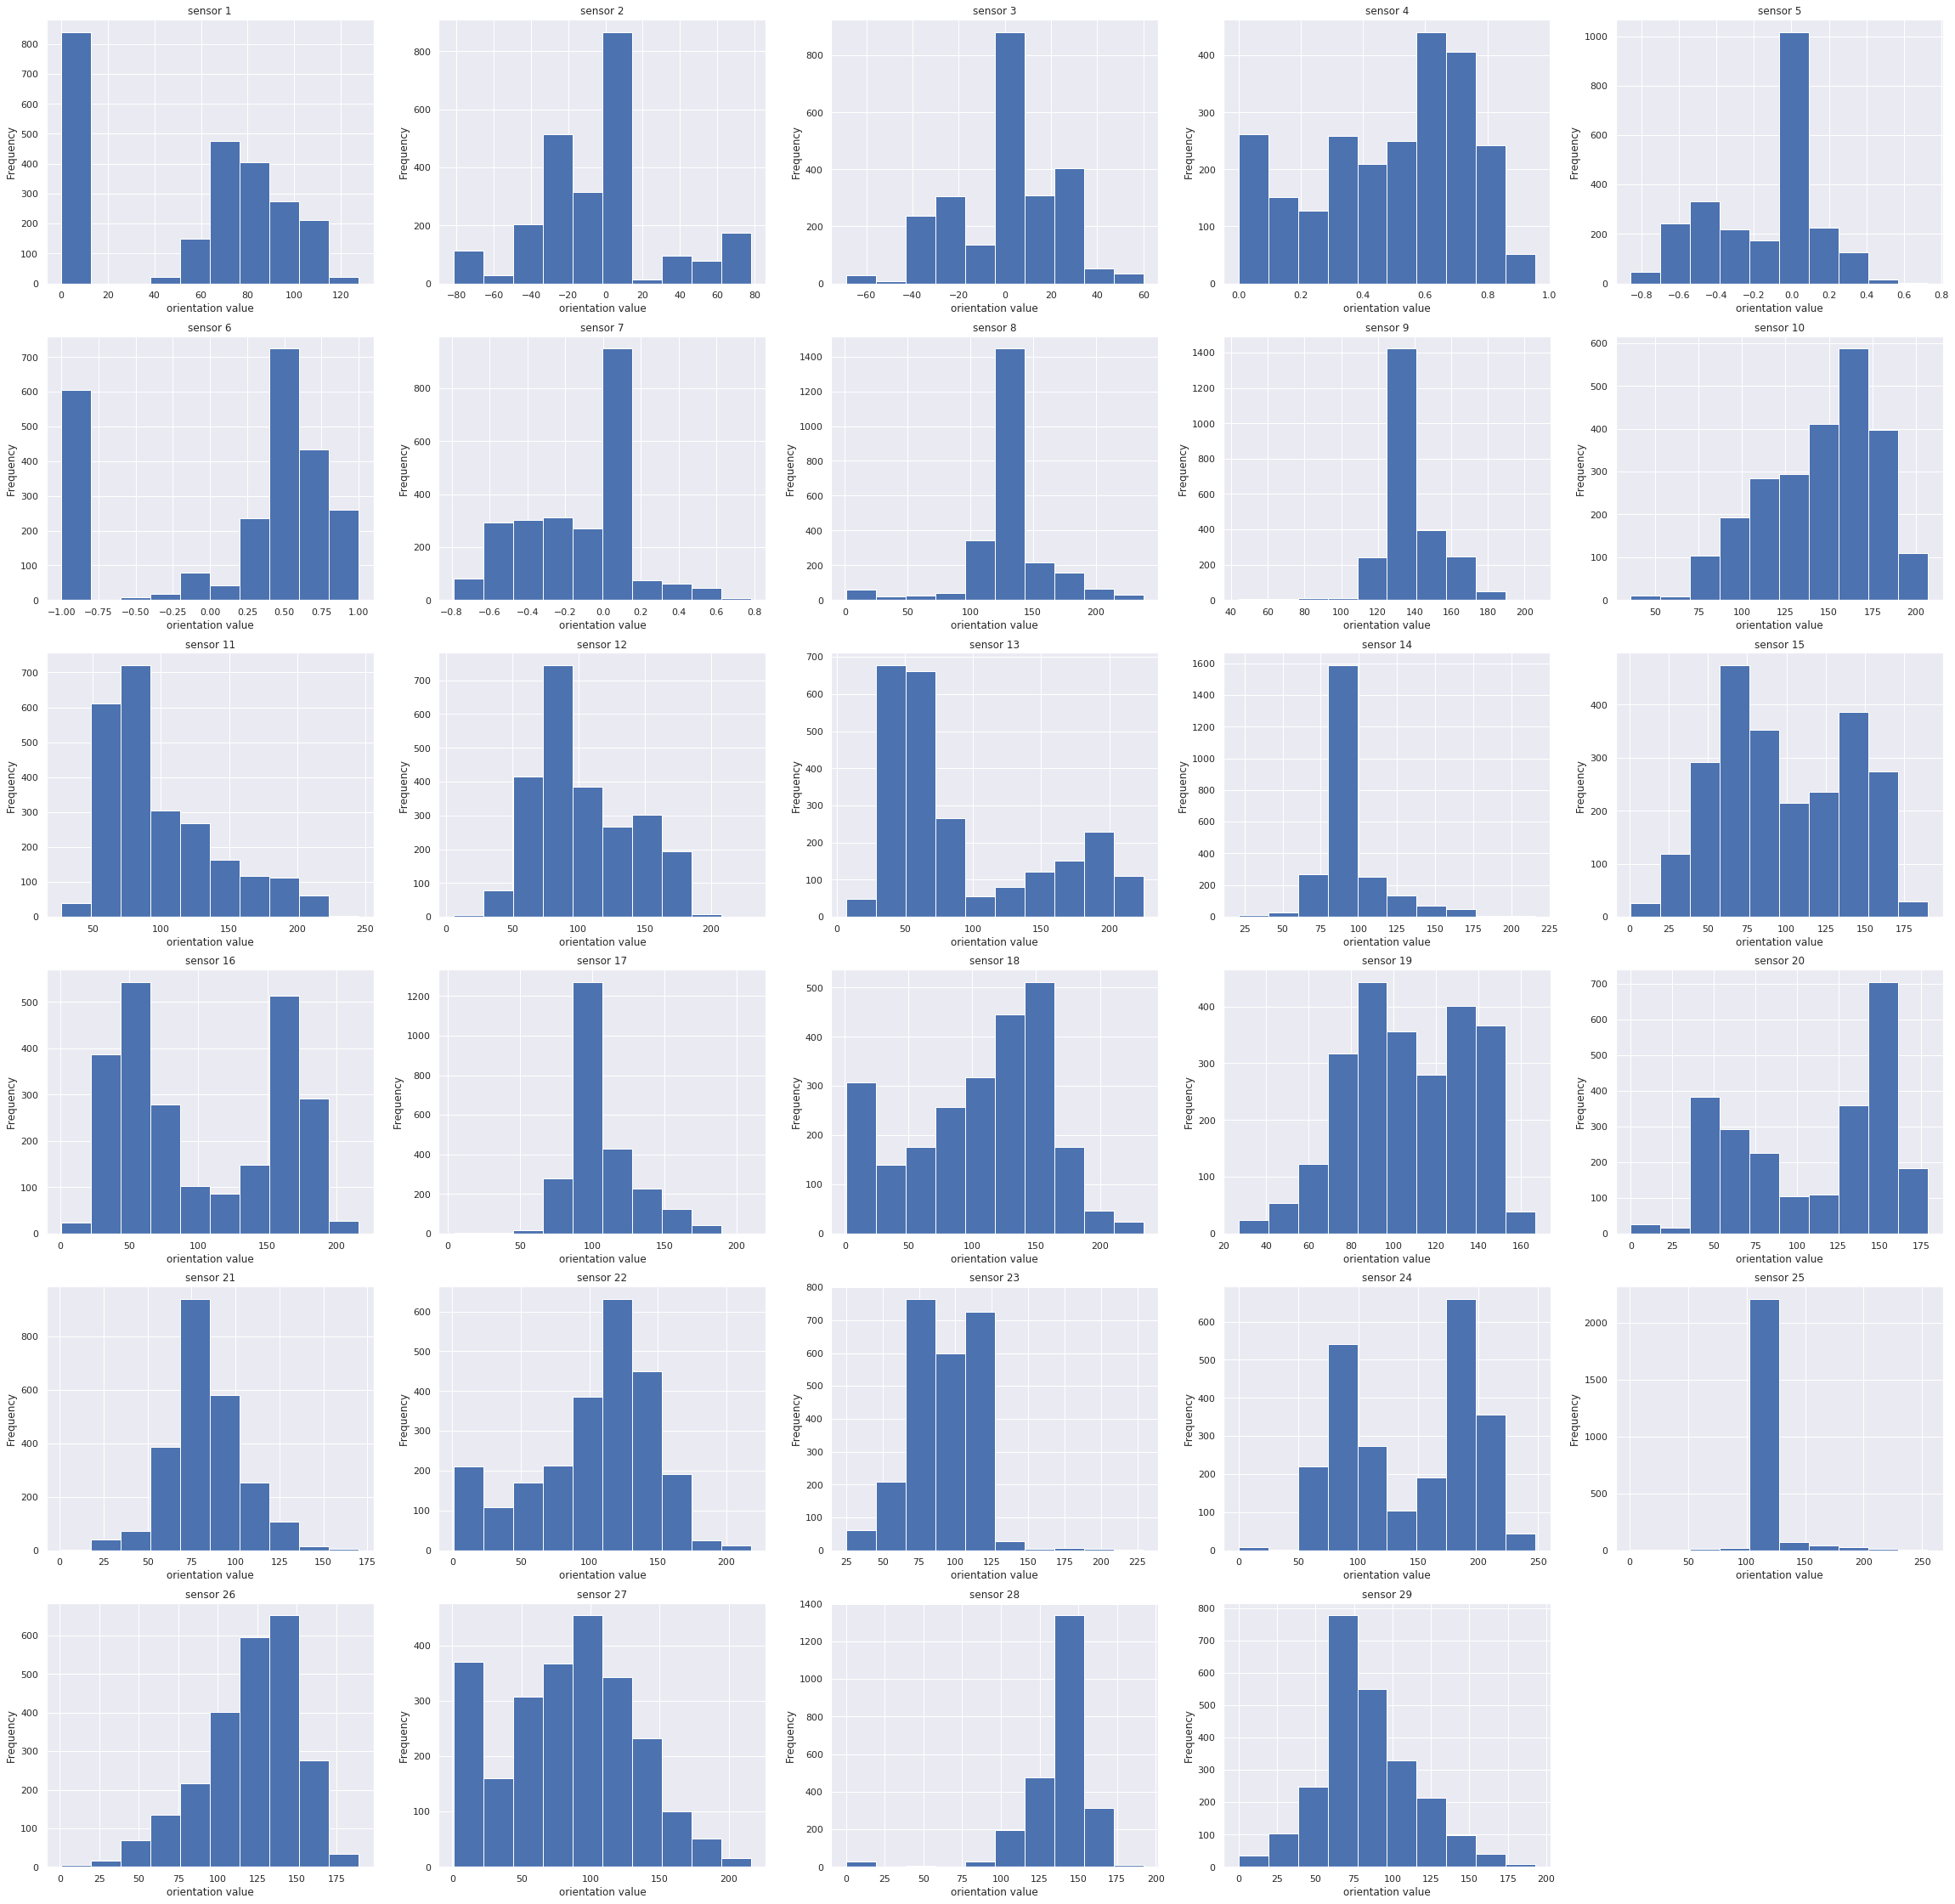

In [293]:
plt.figure(figsize=(40,40))
for i in range(1,30):
    plt.subplot(6,5,i)
    plt.title('sensor '+str(i))
    plt.hist(features[str(i)+'_colx'])
    plt.xlabel("orientation value")
    plt.ylabel("Frequency")
plt.savefig("standardisation_.png")


# OUTILIERS DETECTION

In [294]:
def chauvenet(array):
    mean = array.mean()           # Mean of incoming array
    stdv = array.std()            # Standard deviation
    N = len(array)                # Lenght of incoming array
    criterion = 1.0/(2*N)         # Chauvenet's criterion
    d = abs(array-mean)/stdv      # Distance of a value to mean in stdv's
    prob = special.erfc(d)                # Area normal dist.    
    return prob < criterion 

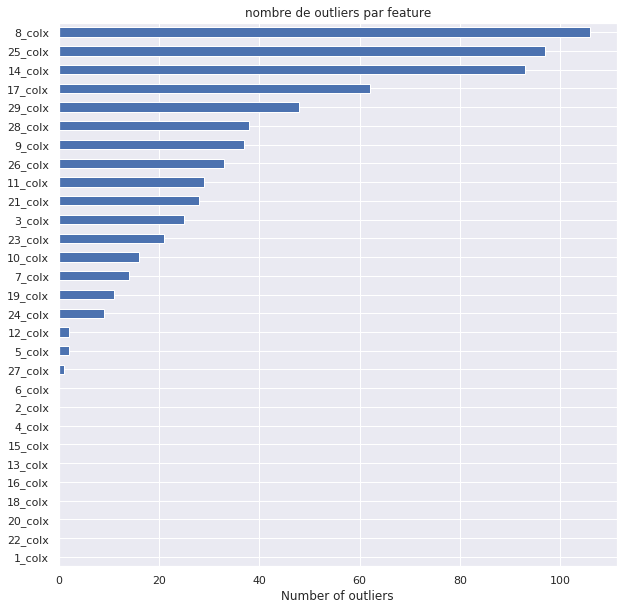

In [295]:
train_outliers = dict()
sns.set()
indexes=[]
for col in xycols[:-1]:
    indexes.append(list(features[chauvenet(features[col].values)].index))
    train_outliers[col] = features[chauvenet(features[col].values)].shape[0]
train_outliers = pd.Series(train_outliers)
plt.title('nombre de outliers par feature')
train_outliers.sort_values().plot(figsize=(10, 10), kind='barh').set_xlabel('Number of outliers')
plt.savefig("outliers.png")


In [296]:
from functools import reduce 
indexes_=reduce(lambda x, y: x+y, indexes)
indexes_to_eliminate= list(set(indexes_))
print('le nombre d observations contenant des outliers est: ', len(indexes_to_eliminate))

le nombre d observations contenant des outliers est:  449


In [297]:
print('les indices des valeurs abérantes sont',np.array(indexes_to_eliminate))

les indices des valeurs abérantes sont [   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   24   26   40 2090   43   44
   60   61   63   64   65   66   68   70   71   75   80 2132   84  100
  101  102  103  104  105  106  107  108  109  110  111  112  113  114
  115  116  117 2166  119  120  121  118  123  124  125  126  127  122
  128  130  131  132  133  129 2176 2177  137  134  139  140  141 2187
  135  144  136  138 2196 2197 2203 2204  160  161 2210  164 2213 2216
 2217 2225 2227  180  181  184 2233 2235 2236 2237 2240 2244  200 2249
 2250  204 2261 2265  220  221  222  223  224  225  226  227  228  229
  230  231  232  233  234  235  236  237  238  239  240 2286 2288 2291
  244 2297 2298 2300 2302 2306  260  261  262  263  264 2313  266 2309
  268  269 2314  272  275 2324  280  281  282  283  284 2331 2332 2334
 2338  293  294  300  301  304 2360 2367  320  321  323  324  325  327
  330 2378  340  341  342  343  344  3

# CORROLEATION STUDY

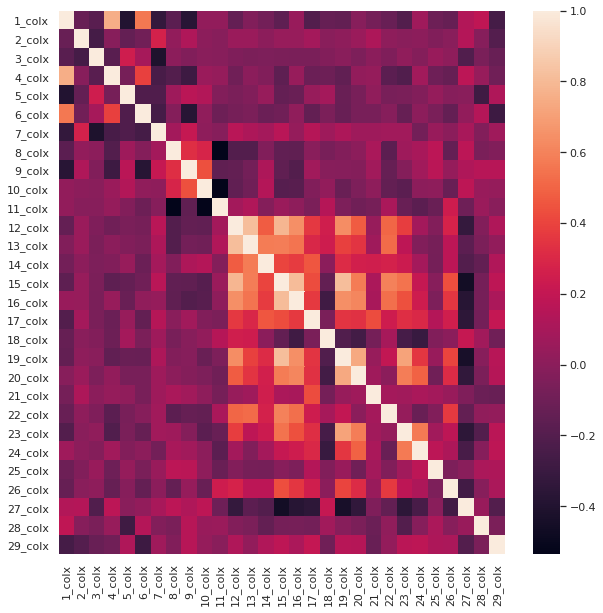

In [66]:
correlation=features.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation)
plt.savefig('correlation.png')

In [67]:
columns = np.full((correlation.shape[0],), True, dtype=bool)
features_correlated=[]
for i in range(correlation.shape[0]):
    for j in range(i+1, correlation.shape[0]):
        if correlation.iloc[i,j] >= 0.8:
            features_correlated.append((i,j))
            if columns[j]:
                columns[j] = False
selected_columns = features.columns[columns]
features_not_correlated= features[selected_columns]

In [68]:
features_not_correlated.columns

Index(['1_colx', '2_colx', '3_colx', '4_colx', '5_colx', '6_colx', '7_colx',
       '8_colx', '9_colx', '10_colx', '11_colx', '12_colx', '14_colx',
       '15_colx', '17_colx', '18_colx', '20_colx', '21_colx', '22_colx',
       '23_colx', '24_colx', '25_colx', '26_colx', '27_colx', '28_colx',
       '29_colx'],
      dtype='object')

In [69]:
print('features correlated are',features_correlated)

features correlated are [(11, 12), (14, 15), (14, 18)]


/home/ghada/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ghada/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Feature: 0, Score: 0.00189
Feature: 1, Score: 0.01307
Feature: 2, Score: 0.01827
Feature: 3, Score: 0.00272
Feature: 4, Score: 0.00745
Feature: 5, Score: -0.00205
Feature: 6, Score: 0.00042
Feature: 7, Score: -0.01697
Feature: 8, Score: 0.04627
Feature: 9, Score: -0.03727
Feature: 10, Score: 0.06561
Feature: 11, Score: 0.03164
Feature: 12, Score: -0.06987
Feature: 13, Score: 0.00780
Feature: 14, Score: -0.06484
Feature: 15, Score: 0.01312
Feature: 16, Score: -0.01237
Feature: 17, Score: 0.02153
Feature: 18, Score: -0.03063
Feature: 19, Score: 0.03640
Feature: 20, Score: 0.01752
Feature: 21, Score: 0.04278
Feature: 22, Score: -0.05727
Feature: 23, Score: -0.02165
Feature: 24, Score: 0.06839
Feature: 25, Score: -0.01722
Feature: 26, Score: -0.01280
Feature: 27, Score: -0.00247
Feature: 28, Score: 0.03712


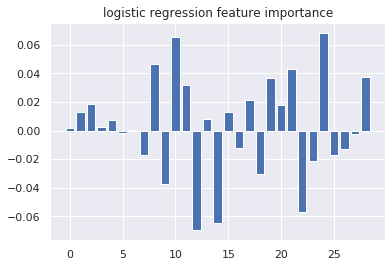

In [70]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
# define the model
model = LogisticRegression()
# fit the model
model.fit(features, targets)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.title ('logistic regression feature importance')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.savefig('features_selection.png')
pyplot.show()


/home/ghada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Feature: 0, Score: 0.00178
Feature: 1, Score: 0.00328
Feature: 2, Score: 0.01220
Feature: 3, Score: 0.07353
Feature: 4, Score: 0.07844
Feature: 5, Score: 0.02694
Feature: 6, Score: 0.02829
Feature: 7, Score: 0.03890
Feature: 8, Score: 0.05214
Feature: 9, Score: 0.06695
Feature: 10, Score: 0.03471
Feature: 11, Score: 0.04876
Feature: 12, Score: 0.09124
Feature: 13, Score: 0.00848
Feature: 14, Score: 0.01946
Feature: 15, Score: 0.02833
Feature: 16, Score: 0.00524
Feature: 17, Score: 0.10574
Feature: 18, Score: 0.01117
Feature: 19, Score: 0.07174
Feature: 20, Score: 0.00842
Feature: 21, Score: 0.03585
Feature: 22, Score: 0.01339
Feature: 23, Score: 0.08057
Feature: 24, Score: 0.00267
Feature: 25, Score: 0.01146
Feature: 26, Score: 0.01075
Feature: 27, Score: 0.01546
Feature: 28, Score: 0.01415


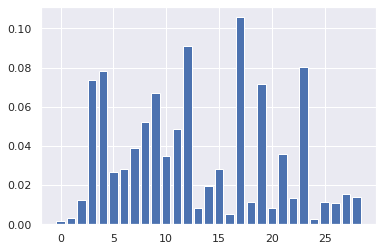

In [72]:
# decision tree for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define the model
model = RandomForestRegressor()
# fit the model
model.fit(features, targets)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# SCALING

In [298]:
from sklearn import preprocessing

In [299]:
scaler = preprocessing.StandardScaler().fit(X)
X_ = scaler.transform(X)

# ONE HOT ENCODING

In [300]:
names = [
        "Nearest Neighbors",
        "Decision Tree",
        "Random Forest",
        "SVM"

        ]

In [301]:
classifiers = [
        KNeighborsClassifier(5, p=3, algorithm='auto'),
        DecisionTreeClassifier(max_depth=30),
        RandomForestClassifier(40, max_depth=10),
        SVC(kernel="rbf", C=1)

        ]

In [302]:
import os
import random
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(1337)
random.seed(12345)

In [303]:
from sklearn.model_selection import cross_validate

In [304]:
scores = []
for name, clf in zip(names, classifiers):
    print(' ::: %s :::' % (name))  
    scores_model= cross_validate(clf, X_, T.ravel(), cv=5)
    fit_time=np.mean(scores_model['fit_time'])
    score_time=np.mean(scores_model['score_time'])
    accuracy_mean=np.mean(scores_model['test_score'])
    print('fit time =' , fit_time,   'score_time=',score_time,'test_score=',accuracy_mean)
    print('_________________________________')
    scores.append(scores_model)


 ::: Nearest Neighbors :::
fit time = 0.006109905242919922 score_time= 1.8338202953338623 test_score= 0.8149999999999998
_________________________________
 ::: Decision Tree :::
fit time = 0.030764150619506835 score_time= 0.0005326747894287109 test_score= 0.8225
_________________________________
 ::: Random Forest :::
fit time = 0.3407579898834229 score_time= 0.013247346878051758 test_score= 0.9195833333333333
_________________________________
 ::: SVM :::
fit time = 0.1929169178009033 score_time= 0.062046146392822264 test_score= 0.9308333333333334
_________________________________


# OUTLIERS ELIMINATION

In [305]:
features.drop(indexes_to_eliminate,inplace=True)
targets.drop(indexes_to_eliminate,inplace=True)
features__=features.to_numpy()
targets__=targets.to_numpy().reshape(1951,)

In [306]:
scores = []
for name, clf in zip(names, classifiers):
    print(' ::: %s :::' % (name))  
    scores_model= cross_validate(clf,features__,targets__, cv=5)
    fit_time=np.mean(scores_model['fit_time'])
    score_time=np.mean(scores_model['score_time'])
    accuracy_mean=np.mean(scores_model['test_score'])
    print('fit time =' , fit_time,   'score_time=',score_time,'test_score=',accuracy_mean)
    print('_________________________________')
    scores.append(scores_model)

 ::: Nearest Neighbors :::
fit time = 0.0045149803161621095 score_time= 0.6009148120880127 test_score= 0.8467099481933241
_________________________________
 ::: Decision Tree :::
fit time = 0.027914810180664062 score_time= 0.0005308151245117188 test_score= 0.840583644829169
_________________________________
 ::: Random Forest :::
fit time = 0.2037356376647949 score_time= 0.008489751815795898 test_score= 0.9379762607384091
_________________________________
 ::: SVM :::
fit time = 0.10338888168334961 score_time= 0.05222363471984863 test_score= 0.9036264673093317
_________________________________


# GRID SEARCH 

In [307]:
liste_C = [1, 1, 1]
liste_Gamma = [0.0001, 0.001, 0.005, 0.1, 1]
liste_Deg = [1,2,3,4,5]

In [308]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [309]:
X_train, X_test, y_train, y_test = train_test_split(features__, targets__, test_size=0.2, random_state=1)

In [310]:
gscArtiG = GridSearchCV(
        estimator=svm.SVC(kernel='rbf', probability=True),
        param_grid={
            'C': liste_C,
            'gamma': liste_Gamma
        },scoring='neg_mean_squared_error', verbose=1)

grid_result = gscArtiG.fit(X_train,y_train)
best_params = grid_result.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.8min finished


In [317]:
best = svm.SVC(kernel='rbf',probability=True, C=best_params["C"], gamma=best_params["gamma"], verbose=0)
best.fit(X_train,y_train)
print("Parameters -> C:",best_params["C"],"Gamma: ",best_params["gamma"])
print(f"error train: {best.score(X_train, y_train)}, error test: {best.score(X_test,y_test)}\n")

Parameters -> C: 1 Gamma:  0.0001
error train: 0.9903846153846154, error test: 0.9718670076726342



In [318]:
print(f"nb de vecteurs support: {best.support_vectors_.shape[0]}")

nb de vecteurs support: 1000


In [341]:
rfc=RandomForestClassifier(random_state=42)

In [342]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [343]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [344]:
CV_rfc.best_params_


{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 200}

In [345]:
rfc1=RandomForestClassifier(random_state=42, max_features='log2', n_estimators= 200, max_depth=8, criterion='entropy')

In [346]:
rfc1.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [351]:
pred=rfc1.predict(X_test)
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))


Accuracy for Random Forest on CV data:  0.9846547314578005
